# Seizure detection sandbox

## Workspace Preparation

In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')


In [2]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
patient_table = pd.DataFrame(CONFIG["patients"]).sort_values('ptID')
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = patient_table.ptID.to_numpy()

In [3]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
set_seed(5210)

In [4]:
set_seed(5210)

In [5]:
pt = 'HUP235'

## Defining Model Architectures

In [6]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1,:])
        return out

class LRModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Flatten the input along the 'sequence length' dimension
        x = x.squeeze()
        out = self.linear(x)
        return out


## Pulling Ictal Data

In [7]:
 # Defining paths for saved data
raw_datapath = ospj(datapath,pt)
if not os.path.exists(ospj(raw_datapath, "seizures")):
    os.mkdir(ospj(raw_datapath, "seizures"))

In [8]:
seizure_times = pd.read_csv('../HUP235_seizure_times.csv')

In [9]:
# access iEEG
with open('woj_ieeglogin.bin', 'r') as f:
  session = Session('wojemann', f.read())
ds = session.open_dataset('HUP235_phaseII')

# get labels and time series info
chn_labels = clean_labels(ds.get_channel_labels(),'HUP235')
chn_labels = [l for l in chn_labels if l not in ['Cz','Fz']]
print(chn_labels)
timeseries = ds.get_time_series_details('LC01')

#get the sampling frequency
fs = timeseries.sample_rate

['LA01', 'LA02', 'LA03', 'LA04', 'LA05', 'LA06', 'LA07', 'LA08', 'LA09', 'LA10', 'LA11', 'LA12', 'LB01', 'LB02', 'LB03', 'LB04', 'LB05', 'LB06', 'LB07', 'LB08', 'LB09', 'LB10', 'LB11', 'LB12', 'LC01', 'LC02', 'LC03', 'LC04', 'LC05', 'LC06', 'LC07', 'LC08', 'LC09', 'LC10', 'LC11', 'LC12', 'LI01', 'LI02', 'LI03', 'LI04', 'LI05', 'LI06', 'LI07', 'LI08', 'LI09', 'LI10', 'LI11', 'LOC', 'LQ01', 'LQ02', 'LQ03', 'LQ04', 'LQ05', 'LQ06', 'LQ07', 'LQ08', 'LQ09', 'LQ10', 'LQ12', 'LS01', 'LS02', 'LS03', 'LS04', 'LS05', 'LS06', 'LS07', 'LS08', 'LS09', 'LS10', 'LS11', 'LS12', 'LY01', 'LY02', 'LY03', 'LY04', 'LY05', 'LY06', 'LY07', 'LY08', 'LY09', 'LY10', 'LY11', 'LY12', 'LZ01', 'LZ02', 'LZ03', 'LZ04', 'LZ05', 'LZ06', 'LZ07', 'LZ08', 'LZ09', 'LZ10', 'LZ11', 'LZ12', 'ROC']


In [15]:
# Iterate through each seizure and run Andy's preprocessing and save it
for i_sz,row in seizure_times.iterrows():
    if i_sz not in [0,5,9]:
        continue
    print(f"Saving seizure number: {i_sz}")
    seizure,fs = get_iEEG_data(usr,'woj_ieeglogin.bin',
                                row.iEEG_ID,
                                (row.Onset-60)*1e6,
                                (row.Offset+60)*1e6,
                                chn_labels,
                                force_pull = True)
    chs = seizure.columns.to_list()
    ch_df = check_channel_types(chs)
    # plot_iEEG_data(seizure,np.arange(len(seizure))/fs)
    # Bipolar montage
    seizure_bp_np,bp_ch_df = bipolar_montage(seizure.to_numpy().T,ch_df)
    bp_ch = bp_ch_df.name.to_numpy()
    # plot_iEEG_data(pd.DataFrame(seizure_bp_np.T,columns=bp_ch),np.arange(len(seizure))/fs)
    # Bandpass filtering
    b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
    seizure_bp_filt = sc.signal.filtfilt(b,a,seizure_bp_np,axis=1)
    # Down sampling
    factor = 4
    seizure_bpd = sc.signal.decimate(seizure_bp_filt,4).T
    fsd = fs/4
    seizure_bpd_df = pd.DataFrame(seizure_bpd,columns = bp_ch)
    # plot_iEEG_data(pd.DataFrame(seizure_bpd,columns=bp_ch),np.arange(len(seizure_bpd))/fsd)
    seizure_bpd_df.to_pickle(ospj(raw_datapath,"seizures",f"det256_seizure_{i_sz}_stim_{0}.pkl"))

Saving seizure number: 0
Saving seizure number: 5
Saving seizure number: 9


## Training Unsupervised Models

In this section I need to create a model for each channel. The current plan is to pull ten seconds of data per channel and then train an autoregressive model per channel. Each of these models would be saved into a dictionary keyed to the channel name. Another idea would be to have just one model that operates on all channels at the same time and even allows cross talk. Starting with the second idea.

In [21]:
d = ds.get_data(60000*1e6,
 (seizure_times.loc[0,'Offset']-seizure_times.loc[0,'Onset'])*1e6,
  [chn_labels.index('LC01')])
d_ictal = ds.get_data(seizure_times.loc[0,'Onset']*1e6,
 (seizure_times.loc[0,'Offset']-seizure_times.loc[0,'Onset'])*1e6,
  [chn_labels.index('LC01')])

Text(0.5, 0.98, 'HUP235 - LC01')

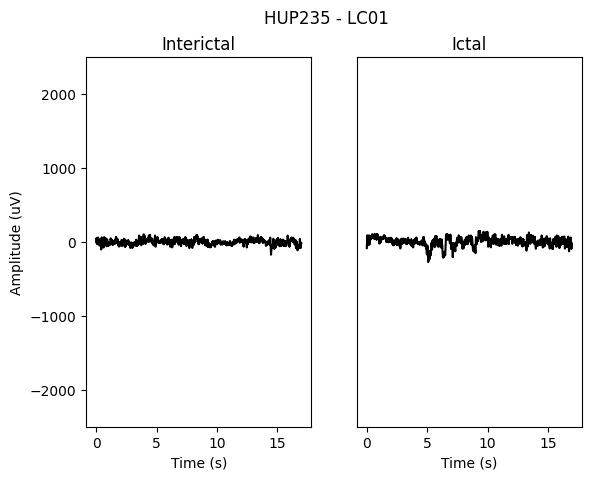

In [22]:
t = np.arange(len(d))/fs
fig,axs = plt.subplots(1,2)
axs[0].plot(t,d,'black')
axs[0].set_ylim([-2500,2500])
axs[0].set_title('Interictal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (uV)')
axs[1].plot(t,d_ictal,'black')
axs[1].set_yticks([])
axs[1].set_title('Ictal')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylim([-2500,2500])

plt.suptitle('HUP235 - LC01')

In the plot of the interictal clip, you can see what we call an epileptiform spike around 4 seconds in. Why might it cause problems if we train our seizure detection algorithm on a window containing the spike? (1 pts)

### 2 (5 pts)

Now that we have real EEG data, we'll be using the model architecture that we developed in the previous section to build a seizure detector. Before we train and test our deep learning models, we need to prepare our training data. We're going to use the first second of the interictal clip at 60000s as our training data.

#### 2a
Downsample the training sample to 512Hz, and build a hankel matrix for the first channel, `LC01`, based on 12 input samples and 1 output sample (the same as the first section). Plot the downsampled EEG clip and print the shape of your hankel matrix (2 pts).

In [ ]:
# Downsampling
dds = sc.signal.decimate(d.T,2).T
# Getting first second
dsec = dds[:512]
# Plotting
plt.plot(dsec)

In [ ]:
train_win =25
pred_win = 1
j = len(dsec)-(train_win+pred_win)
data_mat = torch.tensor(hankel(dsec[:j],dsec[j:])).unsqueeze(2)
print(data_mat.shape)

#### 2b
Now let's do the machine learning part again! You can use your same code from part one to create input and target data, initialize the dataloader, and initialize the model. Then run the training loop to train a new model for the one-second interictal clip while again printing out the loss every 10 epochs. (3 pts)

Hint: The final loss should be around 6459.4541, much higher than when training on a perfect oscillator like before!

In [ ]:
# Prepare input and target data for the LSTM
input_data = data_mat[:,:-1,:].float()
target_data = data_mat[:,-1,:].float()

dataset = TensorDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# Instantiate the model
input_size = input_data.shape[2]
hidden_size = 100
output_size = input_data.shape[2]

In [ ]:
# Initialize the model
# model = LSTMModel(input_size, hidden_size, output_size)
model = LRModel(train_win,1)
print(model)
ccheck = torch.cuda.is_available()
if ccheck:
   model.cuda()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        if ccheck:
            inputs = inputs.cuda()
            targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 9:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
def predict(model, clip, ins = train_win, outs = 1):
    j = len(clip)-(ins + outs)
    data_mat = torch.tensor(hankel(clip[:j],clip[j:])).unsqueeze(2)

    dataset = TensorDataset(data_mat[:,:-outs,:].float(),data_mat[:,-outs,:].float())
    dataloader = DataLoader(dataset,shuffle=False)
    ccheck = torch.cuda.is_available()
    if ccheck:
        model.cuda()
    with torch.no_grad():
        model.eval()
        mse_distribution = []
        for inputs, targets in dataloader:
            if ccheck:
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            mse = criterion(outputs, targets)
            mse_distribution.append(mse.item())
    return np.array(mse_distribution)

In [ ]:
def predict_values(model, clip,ins = train_win, outs = 1):
    j = len(clip)-(ins + outs)
    data_mat = torch.tensor(hankel(clip[:j],clip[j:])).unsqueeze(2)

    dataset = TensorDataset(data_mat[:,:-outs,:].float(),data_mat[:,-outs,:].float())
    dataloader = DataLoader(dataset,shuffle=False)

    with torch.no_grad():
        model.eval()
        predictions = []
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.item())
    return np.array(predictions)

### 3 (7 pts)

#### 3a
Pull the first second of the first seizure in the csv, along with 1 second of interictal data starting at the given interictal time for the same seizure from `HUP235_phaseII` iEEG file. (2 pts)

In [ ]:
ictal = ds.get_data(seizure_times.loc[0,'Onset']*1e6,1*1e6,[chn_labels.index('LC01')])
ictal = sc.signal.decimate(ictal.T,2).T

inter = ds.get_data(seizure_times.loc[0,'Interictal']*1e6,1*1e6,[chn_labels.index('LC01')])
inter = sc.signal.decimate(inter.T,2).T

#### 3b
Generate mse distributions for each of the three clips (training clip, interictal clip, ictal clip) using your predict function from section 1 (1 pt).

In [ ]:
train_mse = predict(model,dsec)
inter_mse = predict(model,inter)
ictal_mse = predict(model,ictal)


#### 3c
Now, make three subplots in a 18 x 6 (W x H) figure: 1. plotting the interictal clip (blue) and ictal clip (red) with a legend (maintain this ictal/interictal color sceme through all three plots). 2. plot the loss of each clip with segments on the x axis and loss on the y axis. 3. Plot boxplots of the distributions of log-transformed MSE for the interictal and ictal clips, as well as an orange horizontal line at the 95th percentile of the loss the model generates on the TRAINING interictal clip (the one starting at 60000s). (4 pts)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].plot(inter,c='blue',label='Interictal')
ax[0].plot(ictal,c='red',label='Ictal')
ax[0].legend()
ax[0].set_title('EEG Signal')
sns.scatterplot(inter_mse,c='blue',ax=ax[1])
sns.scatterplot(ictal_mse,c='red',ax=ax[1])
ax[1].set_title('Prediction Loss')
ax[1].set_ylabel('Loss (MSE)')
plot_data = {'interictal':inter_mse,'ictal':ictal_mse}
pal = {'interictal':'blue','ictal':'red'}
sns.boxplot(pd.DataFrame(plot_data),ax=ax[2],order=['interictal','ictal'],palette=pal)
ax[2].set_yscale('log')
ax[2].set_ylabel('Log Transformed MSE')
ax[2].set_title('Loss Distributions')
ax[2].axhline(np.percentile(train_mse,85),color='orange')

You can see from the plot, that the MSE values are going to make a great feature for detecting seizures.  Now that you've done this for one seizure on one channel, we're going to scale things up a little bit...

### 4 (15 pts)
We're going to deviate from the paper here for simplicity. Instead of using their unsupervised clustering algorithm, we're going to just use the 95th percentile of interictal loss from  as our decision boundary and use it to threshold the mean MSE value of new clips to predict ictal (above) or interictal (below).

#### 4a
To evaluate our model on it's ability to determine if any given one second clip comes from a seizure or is interictal, we need to write a new prediction function that converts an input clip into an ictal/interictal classifier. Try it out on the ictal clip from the previous question - it should predict Ictal! (3 pts)

In [ ]:
def clf(clip, model=model, threshold=np.percentile(inter_mse,95)):
    j = len(clip)-(train_win+1)
    data_mat = torch.tensor(hankel(clip[:j],clip[j:])).unsqueeze(2)

    with torch.no_grad():
        model.eval()
        inputs = data_mat[:,:-1,:].float()
        targets = data_mat[:,-1,:].float()
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        outputs = model(inputs)
        mse = criterion(outputs, targets)

    return mse.item() > threshold

In [ ]:
clf(ictal)

Now that we can generate predictions on a new clip, let's formulate our machine learning problem. We're going to be trying to classify ictal vs. interictal on the `LC01` channel for `HUP235_phaseII` across all seven of their seizures. To create a balanced dataset for evaluating our model we need to have equal numbers of interictal and ictal clips. What are some limitations to using equal numbers of seizure and normal data when we think about translating this algorithm to an implanted device? (2 pts).

In [ ]:
# Your answer here


#### 4b
Because the seizures are not an even number of seconds (it would be weird if they were), we're going to round down to the nearest integer number of seconds for each seizure (16.57s -> 16s -> 16 clips).

Now, using all of the tools/lines of code from the previous questions, make two seperate matrices, one for interictal and one for ictal clips. The dimensions of the tensors should be num_clips x clip samples. You should include all of the 1 second clips from every seizure and every matched interictal period. Remember to follow all of the signal preprocessing steps! (6 pts)

In [ ]:
ictal_clips = []
inter_clips = []
for i,row in seizure_times.iterrows():
    ictal = ds.get_data(row.Onset*1e6,np.floor(row.Offset-row.Onset)*1e6,[chn_labels.index('LB01')])
    dfs = fs/2
    ictal = sc.signal.decimate(ictal.T,2).T
    ictal_mat = np.reshape(ictal,(-1,int(1*dfs)))
    ictal_clips.append(ictal_mat)

    inter = ds.get_data(row.Interictal*1e6,np.floor(row.Offset-row.Onset)*1e6,[chn_labels.index('LB01')])
    inter = sc.signal.decimate(inter.T,2).T
    inter_clips.append(np.reshape(inter,(-1,int(1*dfs))))
ictal_clips = np.vstack(ictal_clips)
inter_clips = np.vstack(inter_clips)

We need to turn our ictal and interictal clips into a dataset that we can use to evaluate the capabilities of our model. Combine them into one matrix, and create a vector with the same number of rows that contains the target labels for each clip (1 for ictal, 0 for interictal). (1 pts)

In [ ]:
val_data = np.vstack([ictal_clips,inter_clips])
val_targets = np.vstack((np.ones((len(ictal_clips),1),dtype=bool),np.zeros((len(inter_clips),1),dtype=bool)))

In [ ]:
val_data.shape

#### 4c
Now, generate predictions on your new testing dataset. This might take a while (~1-2 min if you do one prediction at a time without a GPU, ~20 seconds with GPU) so use tqdm to print how long the prediction will take (1 pts).

In [ ]:
preds = np.zeros((len(val_targets),1))
for i in tqdm(range(len(val_data))):
  preds[i] = clf(val_data[i,:])

Print out the Accuracy, Precision, and Recall of our classifier as well as plotting the confusion matrix (2 pts)

In [ ]:
accuracy = lambda x,y: np.sum(x==y)/len(x)

In [ ]:
print(f"Accuracy: {accuracy(val_targets,preds)}")
print(f"Precision: {precision_score(val_targets,preds)}")
print(f"Recall: {recall_score(val_targets,preds)}")

ConfusionMatrixDisplay(confusion_matrix(val_targets,preds)).plot(cmap = 'plasma')

You can see from the confusion matrix and the metrics that we calculate that our classifier is very good at detecting seizures (high sensitivity), but not very good at discriminating high loss interictal clips from seizures. Why might this be the case? (2 pts)

In [ ]:
# Your answer here

### 5 (10 pts)
Now comes the fun part! Throughout this homework you've learned how to format data for autoregression, build deep learning models, and train and test an LSTM for seizure detection. How you approach this last part of the homework is up to you, but your goal is to try a new method that iterates on the framework we've provided and evaluate it using the testing dataset that we built in 4b.

The Goal: Maximize accuracy and precision while minimizing training data and computational complexity.

The Rules:
* You cannot use any of the data (ictal or interictal clips) that we use to test the model in the previous section to train your model
* You cannot use ANY ictal data to train the model
* The model must be trained in an unsupervised manner
* The rest is up to you!

Write a paragraph describing your proposed method (4 pts). Then, implement your algorithm and print out the accuracy, precision, and recall of your final model. (6 pts + 1 pt Extra Credit for every improved percentage point).
